<a href="https://colab.research.google.com/github/HelmchenLabSoftware/Cascade/blob/master/Demo%20scripts/Explore_ground_truth_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CASCADE

## Visualization of Ground Truth Datasets

[Calcium imaging](https://en.wikipedia.org/wiki/Calcium_imaging) is one of the key methods to study neuronal activity *in vivo*, but it is a noisy and indirect readout. To understand the relationship between neuronal activity and imaged calcium, **ground truth recordings** are crucial but technically challenging. It requires to perform [extracellular juxtacellular recordings](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2373773/) with a patch pipette from a single neuron, while at the same time imaging calcium sensors in the same neuron.

To train a **supervised algorithm, [Cascade](https://github.com/HelmchenLabSoftware/Cascade),** which infers spike rates from calcium signals, we have recorded and collected a large database of ground truth recordings. The database consists of **20 single datasets** (including the [GENIE](https://crcns.org/data-sets/methods/cai-1) [datasets](https://crcns.org/data-sets/methods/cai-2), some of the [Spikefinder datasets](https://crcns.org/data-sets/methods/cai-3), the [Allen Institute datasets](https://portal.brain-map.org/explore/circuits/oephys), and several datasets that we recorded ourselves), covering **7 different brain regions, 8 different calcium indicators, two different species**, totalling more than **20 hours of recording**. More details about the datasets will be available in a preprint that will be made public soon (link will follow).

This interactive notebook is designed to facilitate the exploration of these datasets. Everybody who is using calcium imaging as a standard method has probably wondered what the underlying activity for the observed transients are: **Is it just noise, or an action potential, or a burst of action potentials?** This interactive viewer allows you to explore it for a well-curated and diverse dataset. Enjoy it!

This interactive viewer was written by [Adrian Hoffmann](https://github.com/AdrianHoffmann), together with [Peter Rupprecht](https://github.com/PTRRupprecht).


##1. Load data and import/download required code

In [4]:
#@markdown To execute the code, click on the **play** symbol on the left of each cell.

#@markdown When executed in the Colaboratory environment, the code will download the [Cascade](https://github.com/HelmchenLabSoftware/Cascade) repository into the current environment, including all ground truth datasets with simultaneously recorded fluorescence and spiking activity. This will take a couple of seconds.

#@markdown *Note: You can check the code underlying each cell by double-clicking on it.*

import os

# If in Colab and not yet downloaded, download GitHub repository
if os.getcwd() == '/content': 
    if not os.path.exists('/content/Cascade'):
        !git clone https://github.com/HelmchenLabSoftware/Cascade
    os.chdir('Cascade')
    
# If executed as jupyter notebook on own computer, change to parent directory for imports
if os.path.basename( os.getcwd() ) == 'Demo scripts':
    %cd ..
    print('New working directory:', os.getcwd() )

# set environment variables depending on colab or jupyter environment
if os.getcwd() == '/content/Cascade':
    ENV = 'colab'
else: # assume jupyter
    ENV = 'jupyter'
    %matplotlib notebook

# Imports:
import matplotlib.pyplot as plt
import numpy as np

from cascade2p import utils
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

## Load datasets
datasets = utils.load_all_ground_truth( ground_truth_folder='Ground_truth')
dataset_names = sorted(list( datasets.keys() ))

print('\nSuccessfully loaded ground truth data.')


Successfully loaded ground truth data.


##2. Explore the ground truth data

<IPython.core.display.Javascript object>


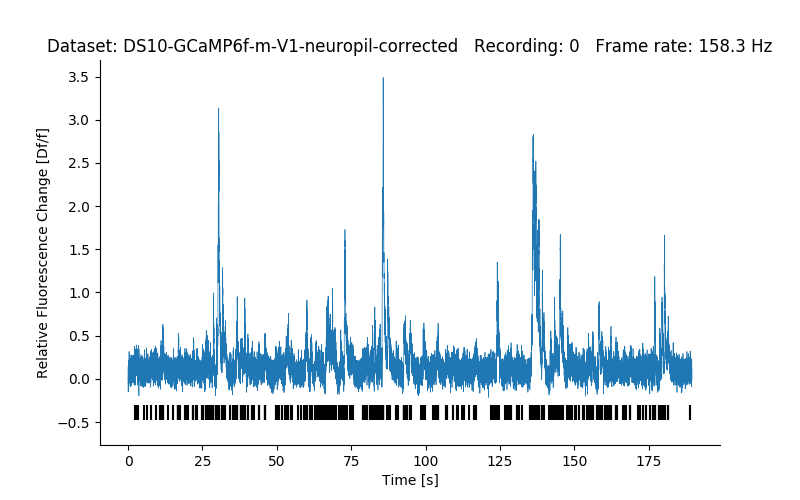

In [7]:

def plot_neuron(Dataset, Recording, Zoom=1, Offset=0):
    """Plot the fluorescence and spikes for a single recording of the dataset
    
    Parameters
    -------
    Dataset: str
        Name of the dataset, which is identical to the folder name in the Ground_truth folder
    Recording: int
        Number of the recording in this dataset, pooled across all files in this dataset
    """

    # correct for different plot sizes in colab and jupyter
    if ENV=='colab':   plt.figure(figsize=(20,8))
    if ENV=='jupyter': plt.figure(figsize=(8,5))
    
    
    data = datasets[Dataset][Recording]
    # plt.cla()
    plt.plot( data['t'][1:], data['dff'][1:], lw=0.5)
    
    max_dff = np.max( data['dff'][1:])
    min_dff = np.min( data['dff'][1:])
    
    plt.eventplot( data['spikes'], lineoffsets=min_dff - max_dff/20,
                  linelengths=max_dff/20, color='k', lw=1.5)
    
    # TODO: add number of APs if they are very close to each other or firing rate
    
    plt.xlabel('Time [s]')
    plt.ylabel('Relative Fluorescence Change [Df/f]')
    plt.title('Dataset: {}   Recording: {}   Frame rate: {:.1f} Hz'.format(Dataset, Recording, data['frame_rate']))
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Adjust zoom and offset
    if (Zoom != 1) or (Offset != 0):
        t_min = Offset
        t_max = (data['t'][-1] / Zoom) + Offset
        plt.xlim( (t_min, t_max) )
    
dataset_widget = widgets.Dropdown(options=dataset_names, value =dataset_names[9] )
recording_widget = widgets.IntSlider(min=0, max=100, step=1, value=0, continuous_update=False)

# update number of recordings depending on dataset
def update_nr_recordings(*args):
    recording_widget.max = len( datasets[dataset_widget.value] ) - 1
    
dataset_widget.observe( update_nr_recordings, 'value')
    
widgets.interact(plot_neuron, Dataset=dataset_widget,
                            Recording=recording_widget,
                            Zoom=widgets.IntSlider(min=1, max=50, step=1, value=1, continuous_update=False),
                            Offset=widgets.IntSlider(min=0, max=100, step=1, value=0, continuous_update=False)            
                )

# update manually the first time:
update_nr_recordings()